# Explore SVD based word embedding

This notebook explores word embeddings that are based on SVD of a possibly transformed word-context matrix. Starting with the raw matrix `counts`

- possilby transform `counts` (e.g. log data, do PPMI transform, normalize rows)
- compute SVD of new matrix
- explore word embeddings e.g. scores plots, word similarity
- explore loadings

The material in this notebook is covered in chapters 15/16 of SLP3
- https://web.stanford.edu/~jurafsky/slp3/15.pdf
- https://web.stanford.edu/~jurafsky/slp3/16.pdf


## data

The github repo comes with a small data set pre computed (from a random sample of 1000 court cases). You can download larger data files from https://drive.google.com/open?id=0B40b05f-8LWtVGsybWw4OTVyV00 then place them in the data/ folder.

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import heapq

from scipy.sparse.linalg import svds, norm
from scipy.sparse import diags, csr_matrix, dok_matrix

# import local code files
import sys, os
sys.path.append(os.getcwd() + '/code/')

# working with word embeddings
from save import load_vocabulary, load_matrix
from ppmi import calc_ppmi
from word_similarity import similarity, closest, vec, angle_between, word_angles
from transform_counts import remove_zero_count_words, normalize_rows
from explore_counts_fun import co_counts_intersection

# exploring/visualizing scores/loadings
from scores_viz import scores_plot, filter_scores
from explore_loadings import top_loading_components, top_loading_words, top_loading_words_df

# only import this if you have plot.ly installed
# from viz_plotly import interactive_scores_plot

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# w2i, i2w = load_vocabulary('data/vocab_small_ex.txt')
# co_counts = load_matrix('data/co_counts_small_ex')
# word_counts = np.load('data/word_counts_small_ex.npy')

# # uncomment this code if you have the larger data file
w2i, i2w = load_vocabulary('data/vocab_10000.txt')
co_counts = load_matrix('data/co_counts_10000')
word_counts = np.load('data/word_counts_10000.npy')

In [3]:
print(co_counts.nnz / (co_counts.shape[1] * co_counts.shape[0]))

co_counts

0.0024232102932713953


<158299x158299 sparse matrix of type '<class 'numpy.float64'>'
	with 60722193 stored elements in Compressed Sparse Row format>

# transform counts

In [33]:
# normalized row by row norms
co_counts_normed = diags(1.0/norm(co_counts, axis=1)) * co_counts 

In [ ]:
co_counts_log = co_counts.copy()
co_counts_log.data = np.log(1 + co_counts.data)

In [34]:
ppmi = calc_ppmi(co_counts)

In [67]:
ppmi_normed = normalize_rows(ppmi)

# SVD of counts matrix

If $X \in \mathbb{R}^{n \times d}$ is a data matrix with the n observations on rows then the rank K SVD is given by
$$X \approx U D V^T$$
where $U \in \mathbb{R}^{n \times K}$ is the matrix of normalized scores and  $V \in \mathbb{R}^{d \times K}$ is the matrix of loadings.

If X is a word-context matrix then U (or UD) gives a word embedding.

In [74]:
%%time
k = 10

normed_scores, sing_vals, loadings = svds(co_counts_normed, k)

loadings = loadings.T
un_normed_scores = normed_scores * sing_vals

CPU times: user 47.8 s, sys: 817 ms, total: 48.6 s
Wall time: 19.8 s


In [75]:
embedding = un_normed_scores

# Explore word embedding (scores)

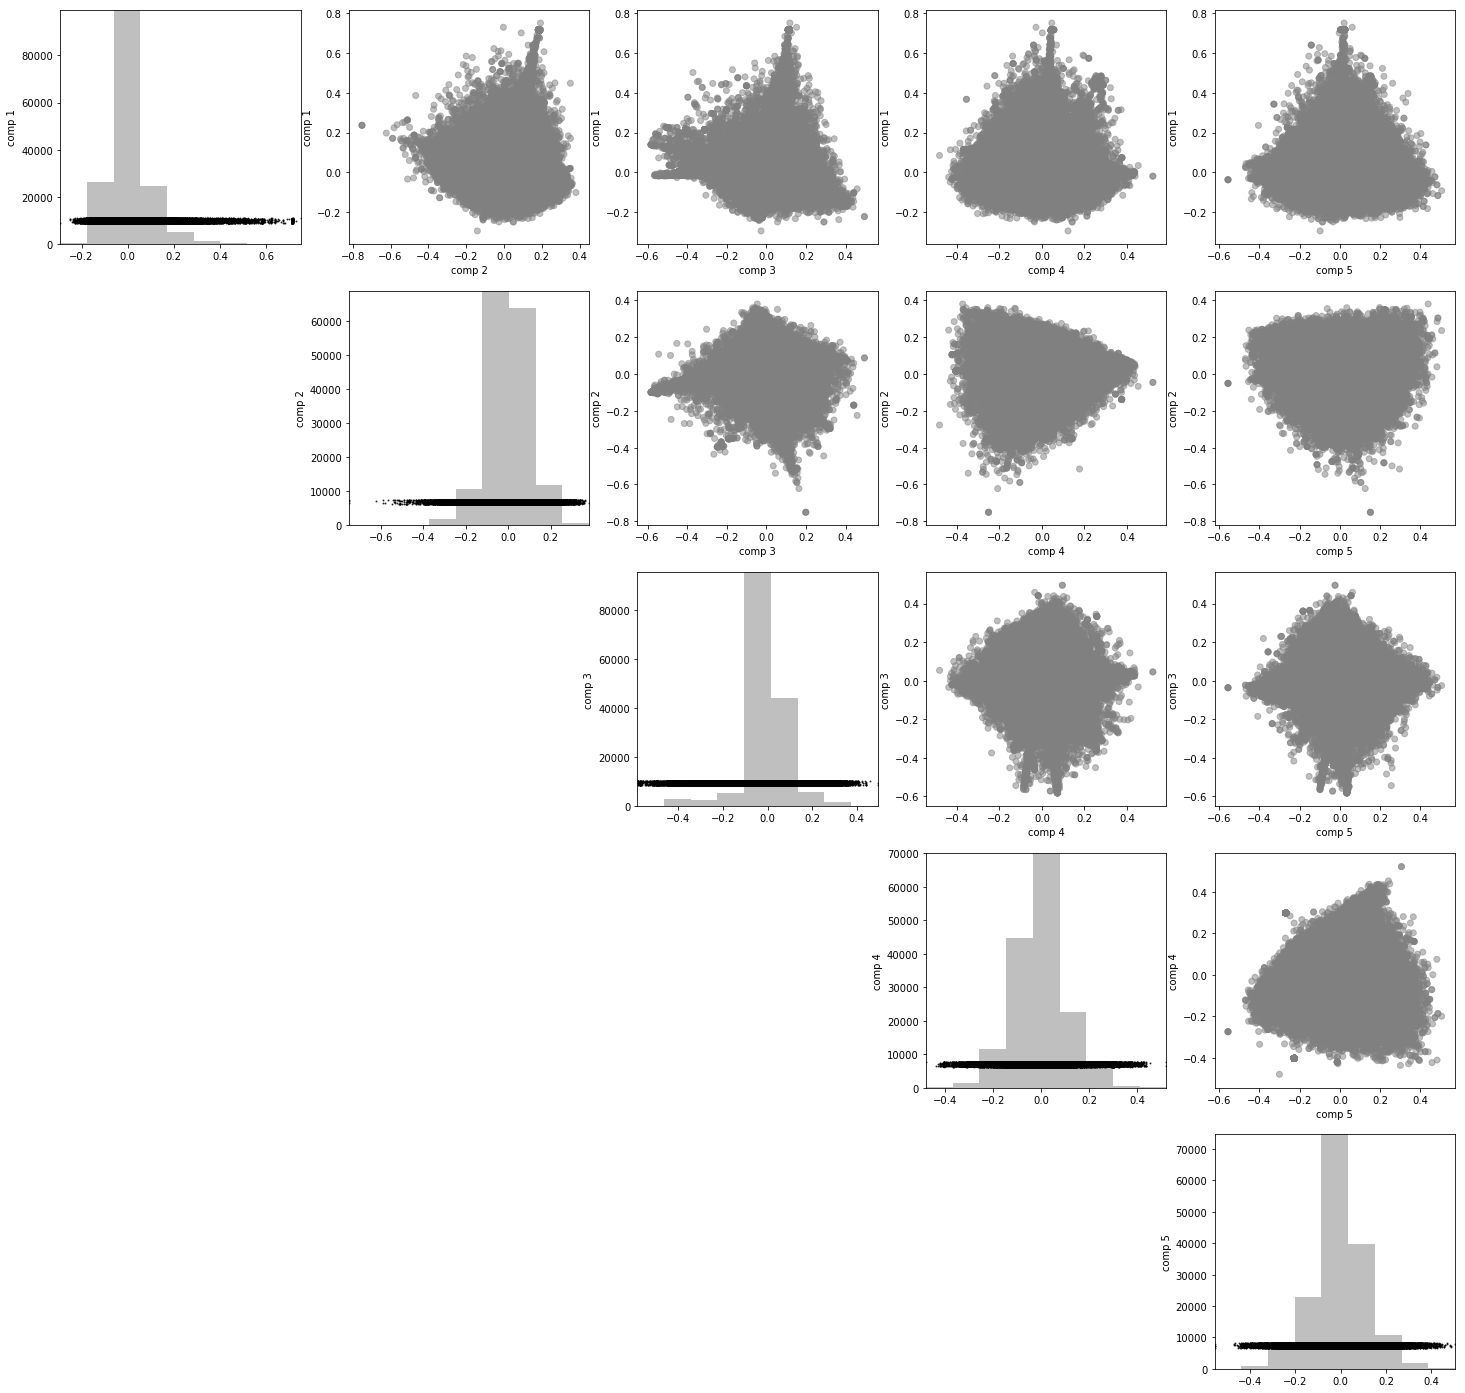

In [76]:
scores_plot(embedding,
            start=1,
            n_comp=5,
            title='',
            comp_names=None)

# simlarity

In [80]:
word1 = 'lawyer'
word2 = 'lawyers'

similarity(word1, word2, embedding, w2i, sim='angle')

12.693060790737427

In [85]:
word = 'lawyers'
closest(word, embedding, w2i, N=50)

['lawyers',
 'psychological',
 'library',
 'emotional',
 'consultants',
 'medical',
 'fraught',
 'naught',
 'financed',
 'leafletting',
 'faculty',
 'divine',
 'women',
 'aider',
 'son',
 'equipped',
 'advising',
 'unarmed',
 'manufacturers',
 'anxiety',
 'abundance',
 'family',
 'posters',
 'ration',
 'weapons',
 'brokers',
 'tyrannical',
 'utilizing',
 'corporal',
 'institute',
 'issuers',
 'cigarette',
 'cards',
 'mands',
 'buhring',
 'tides',
 'attracted',
 'experiments',
 'sufferance',
 'oily',
 'sundays',
 'ease',
 'fresh',
 'planted',
 'television',
 'supervised',
 'services',
 'convenient',
 'thompsons',
 'mwra']

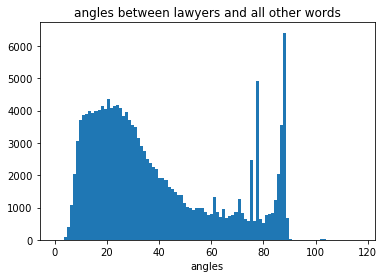

In [88]:
angles = word_angles(word, embedding, w2i)
# angles = [angle_between(embedding[i, :], vec(word, embedding, w2i)) for i in range(embedding.shape[0])]
plt.hist(angles, bins=100)
plt.xlabel('angles')
plt.title('angles between %s and all other words' % word)

In [ ]:
word1 = 'lawyer'
word2 = 'lawyers'
words_both, c1, c2 = co_counts_intersection(co_counts, word1, word2, w2i, i2w, threshold=20)
print(len(words_both))
words_both

# explore loadings

In [ ]:
top_loading_df = top_loading_words_df(loadings, i2w, n=100)

top_loading_df

In [ ]:
comp_numer = 100  # which loading
n = 100 # how many components to show

plt.figure(figsize=[40, 20])

plt.subplot(1,2,1)
top_loading_components(loadings[:, comp_numer], i2w, n, comp_numer)


plt.subplot(1,2,2)
plt.scatter(range(loadings.shape[0]), loadings[:, comp_numer], color='grey')